<a href="https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/06/0608.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing UMAP from scratch


In [1]:
%%capture
!pip install pynndescent

In [2]:
import random

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

import scipy
import scipy.sparse
from scipy.optimize import curve_fit
import numba

from pynndescent import NNDescent

sns.set_theme()
random.seed(2)

## Load the digits dataset

In [3]:
# Load the digits data
mnist = fetch_openml('mnist_784', parser='auto')

# Normalize digits data
mnist_data = mnist.data/255 # DataFrame
mnist_label = mnist.target.astype(object) # Series

# Downsample
mnist_label = mnist_label[(mnist_label.isin(['0', '1', '2', '3', '4']))]

mnist_data = mnist_data.loc[mnist_label.index, :].reset_index(drop=True)
mnist_label = mnist_label.reset_index(drop=True)

In [4]:
mnist_data.shape

(35735, 784)

In [5]:
mnist_label.unique()

array(['0', '4', '1', '2', '3'], dtype=object)

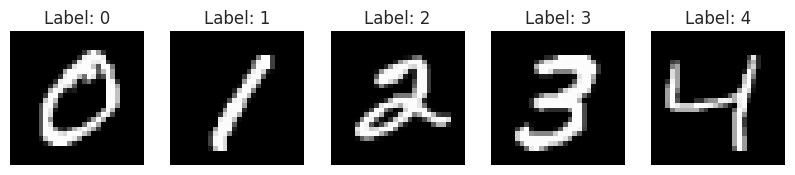

In [6]:
# Initialize a dictionary to store the first instance of each number 0-4
first_instance = {}

# Loop through the dataset to find the first instance for numbers 0-4
for i in range(len(mnist_label)):
    label = mnist_label[i]

    if label not in first_instance:
        first_instance[label] = i

# Plotting
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for label, index in first_instance.items():
    ax = axes[int(label)]
    ax.imshow(mnist_data.loc[index].values.reshape(28, 28), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.show()

## Building a graph


### Find nearest neighbours and distances for each point



In [7]:
N_NEIGHBORS = 20
index = NNDescent(mnist_data, n_neighbors=N_NEIGHBORS)
neighbors, distances = index.query(mnist_data, k=N_NEIGHBORS)

In [8]:
neighbors.shape

(35735, 20)

In [9]:
distances.shape

(35735, 20)

In [10]:
print(neighbors[:20,:5])

[[    0   333 26094 34500 30190]
 [    1 32887 27648 23528  2246]
 [    2    14  4468 18125 26177]
 [    3 23605 34195  5127 12406]
 [    4 34986 15088 10683  4925]
 [    5  6396 30100  2608 27532]
 [    6 26247 30826 26369 35421]
 [    7  2951  7085 35218 28009]
 [    8 21158 29828  1702 29818]
 [    9 10228 31283 32738 13478]
 [   10  9042 20964 20983 32500]
 [   11  1461 12827 28343  4706]
 [   12 11149  4707 26846  2450]
 [   13 19035 33819    68   333]
 [   14 28012 29724     2  7819]
 [   15 11266 21074 18932 14531]
 [   16 10298 30330 29308 33448]
 [   17 15922 22927  3841  8099]
 [   18 14299 21499 24794 19452]
 [   19 10277 12283 27306 20523]]


In [11]:
print(distances[:20,:5])

[[0.        4.0025387 4.3158016 4.3695583 4.413664 ]
 [0.        5.3273163 5.402473  6.0436363 6.093434 ]
 [0.        1.645424  1.6983155 1.7571472 1.7846886]
 [0.        5.7030854 5.7560773 5.8200917 5.8497186]
 [0.        2.0190747 2.169698  2.2051282 2.218336 ]
 [0.        4.404384  4.491249  4.575397  4.7650447]
 [0.        1.6835318 1.7950891 1.7965837 1.8011829]
 [0.        3.0204685 3.9795382 4.3531566 4.4182453]
 [0.        4.191122  4.6941586 4.716273  4.7353053]
 [0.        4.841057  5.006231  5.0831156 5.104592 ]
 [0.        1.193633  1.3076652 1.5288687 1.6061063]
 [0.        5.536782  5.856629  5.882511  5.9822845]
 [0.        4.8734417 5.5431523 5.77564   5.804689 ]
 [0.        4.478986  4.9372363 5.116263  5.144714 ]
 [0.        1.5201428 1.538135  1.645424  1.664215 ]
 [0.        5.50225   5.6558933 5.839876  5.8611617]
 [0.        4.7328944 5.3089194 5.4965177 5.8032618]
 [0.        2.9286034 3.9086022 3.961219  4.0143704]
 [0.        4.7694273 5.038561  5.521318  5.54

In [12]:
neighbors = neighbors[:, 1:]
distances = distances[:, 1:]

Text(0.5, 1.0, 'Neighbor distance from "data point 0"')

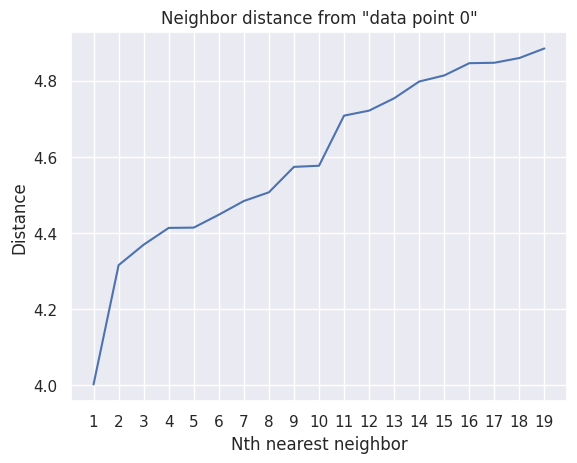

In [13]:
plt.figure()
plt.plot(np.arange(distances.shape[1], dtype=np.int32)+1, distances[0,:])
plt.xlabel('Nth nearest neighbor')
plt.xticks(np.arange(distances.shape[1], dtype=np.int32)+1)
plt.ylabel('Distance')
plt.title('Neighbor distance from "data point 0"')

### Calculate rho for each data point

$$
\rho_i = \min_{j \in S} d(i, j)
$$



In [14]:
rhos = distances[:, 0]
print(rhos[:5])

[4.0025387 5.3273163 1.645424  5.7030854 2.0190747]


### Calculate sigmas


$$
sim_{ij} = \exp \left(- \frac{\max(0, d(x_i, x_{ij}) - \rho_i)}{\sigma_i} \right)
$$ (${\sigma_i}$ 跟 $sim_{ij}$ 成正比)

$$
\sigma_i = \text{the value such that } \sum_{j=1}^{k} \exp \left(- \frac{\max(0, d(x_i, x_{ij}) - \rho_i)}{\sigma_i} \right) = \log_2(k)
$$


In [15]:
# Set parameter values for binary search
BINARY_ITER = 64
GAMMA_TOLERANCE = 1e-5

# Log target is same everywhere
log_target = np.log2(N_NEIGHBORS)

In [16]:
# Example - binary search for a single row
curr_dist = distances[0,:]

# Set up binary search for sigma
sigma_high = np.inf
sigma_low = 0
sigma_mid = 1

# Perform N itterations
for iter_i in range(BINARY_ITER):
    # Substract distances and rho
    dist_diff = curr_dist - rhos[0] # (19,) - ()

    # Divide by sigma, negate, perform exponent, sum
    sigma_sum = np.sum(np.exp(-dist_diff/sigma_mid))

    # Break the loop if sum is equal to the target
    if np.abs(sigma_sum-log_target) < GAMMA_TOLERANCE:
        break

    # If obtained sum is greater than the target then make sigma smaller
    if sigma_sum > log_target:
        sigma_high = sigma_mid
        sigma_mid = (sigma_high + sigma_low)/2
    # If obtained sum is lower than the target then make sigma higher
    else:
        sigma_low = sigma_mid
        if sigma_high == np.inf:
            sigma_mid = sigma_mid*2
        else:
            sigma_mid = (sigma_high + sigma_low)/2

print('Obtained sigma sum is : {}'.format(sigma_sum))
print('Target sigma sum is : {}'.format(log_target))
print('Value of sigma is : {}'.format(sigma_mid))

Obtained sigma sum is : 4.321928024291992
Target sigma sum is : 4.321928094887363
Value of sigma is : 0.34084129333496094


Text(0.5, 1.0, 'Neighbor similarity to "data point 0"')

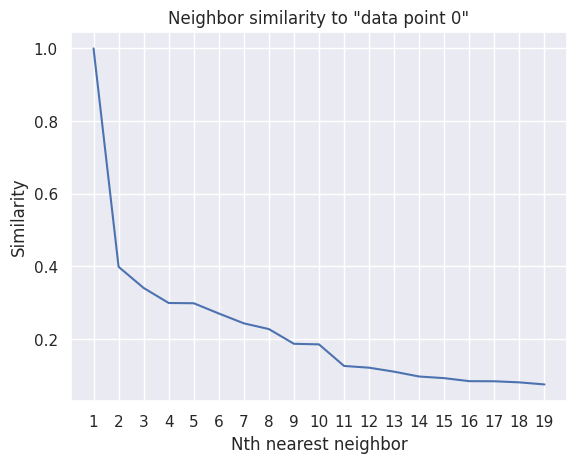

In [17]:
sims_1 = np.exp(-((curr_dist - rhos[0]) / (sigma_mid)))

plt.figure()
plt.plot(np.arange(distances.shape[1], dtype=np.int32)+1, sims_1)
plt.xlabel('Nth nearest neighbor')
plt.xticks(np.arange(distances.shape[1], dtype=np.int32)+1)
plt.ylabel('Similarity')
plt.title('Neighbor similarity to "data point 0"')

In [18]:
# Wrap binary search into function
def binary_search_for_sigma(curr_dist, curr_rho, log_target, binary_iter, smooth_k_tolerance):
    # Set up binary search for sigma
    sigma_high = np.inf
    sigma_low = 0
    sigma_mid = 1

    # Perform N itterations
    for _ in range(binary_iter):
        # Substract distances and rho
        dist_diff = curr_dist - curr_rho

        # Divide by sigma, negate, perform exponent, sum
        sigma_sum = np.sum(np.exp(-dist_diff/sigma_mid))

        # Break the loop if sum is equal to the target
        if np.abs(sigma_sum-log_target) < smooth_k_tolerance:
            return sigma_mid

        # If obtained sum is greater than the target then make sigma smaller
        if sigma_sum > log_target:
            sigma_high = sigma_mid
            sigma_mid = (sigma_high + sigma_low)/2
        # If obtained sum is lower than the target then make sigma higher
        else:
            sigma_low = sigma_mid
            if sigma_high == np.inf:
                sigma_mid = sigma_mid*2
            else:
                sigma_mid = (sigma_high + sigma_low)/2
    return sigma_mid

In [19]:
# Calculate sigma value for each sample
sigma_values = np.zeros(distances.shape[0])

for sample_i in range(distances.shape[0]):
    sigma_values[sample_i] = binary_search_for_sigma(
        curr_dist=distances[sample_i,:],
        curr_rho=rhos[sample_i],
        log_target=log_target,
        binary_iter=BINARY_ITER,
        smooth_k_tolerance=GAMMA_TOLERANCE
    )

### Calculate similarities between points

Similarities to neighbours are calculated as:

$$
sim_{ij} = \exp \left(- \frac{\max(0, d(x_i, x_{ij}) - \rho_i)}{\sigma_i} \right)
$$

This similarities are "simetrized" after calculation.

Formula for all the samples:
$$
S = P + P^T - P * P^T
$$

Example formula for two samples:
$$
S = P_(ij) + P_(ji) - P_(ij) * P_(ji)
$$

In [20]:
# Get number of samples and choosen number of neighbours
n_samples = neighbors.shape[0]
n_neighbors = neighbors.shape[1]

# Initialize row, col and val arrays, this will later
# be used to construct sparse matrix in order to symetrize
# smoothed distance matrix.
row_idx = np.zeros(neighbors.size, dtype=np.int32) # will be used to store index of the
col_idx = np.zeros(neighbors.size, dtype=np.int32) # will be used to store index of the neighbours
mtx_vals = np.zeros(neighbors.size, dtype=np.float32) # will be used to store similarity between sample and neighboor

# Loop goint through samples
for i in range(n_samples):
    # Inner loop going through the neighbours
    for j in range(n_neighbors):
        # Calculate similarities in high dimensional space
        val = np.exp(-((distances[i, j] - rhos[i]) / (sigma_values[i])))

        # store sample indexes e.g. [1,1,1,1,2,2,2,2]
        row_idx[i * n_neighbors + j] = i
        # store neighbour indexes e.g. [2,3,4,5,2,3,4,5]
        col_idx[i * n_neighbors + j] = neighbors[i, j]
        # store similarities e.g [0.1, 0.3, 0.2, 0.5, 0.8,0.12, 0.19, 0.97]
        mtx_vals[i * n_neighbors + j] = val

In [21]:
# Create sparse matrix of smoothed distances
# Distances in this matrix are not yet symetric
non_sym_sim_mtx = scipy.sparse.coo_matrix(
    (mtx_vals, (row_idx, col_idx)), shape=(neighbors.shape[0], neighbors.shape[0])
)
non_sym_sim_mtx.eliminate_zeros()

In [22]:
non_sym_sim_mtx.shape

(35735, 35735)

In [23]:
type(non_sym_sim_mtx)

scipy.sparse._coo.coo_matrix

In [24]:
# Transpose smooth distance matrix
non_sym_sim_mtx_t = non_sym_sim_mtx.transpose()

# Multiply smooth distance matrix with its transponse element-wise
prod_matrix = non_sym_sim_mtx.multiply(non_sym_sim_mtx_t)

type(prod_matrix) # 有做運算 scipy 會轉為 csr 或 csc

scipy.sparse._csr.csr_matrix

In [25]:
# Create symetrical smooth distance matrix by using fuzzy set union operation
sim_mtx = non_sym_sim_mtx + non_sym_sim_mtx_t - prod_matrix

# Eliminate all zeroes from the result
sim_mtx.eliminate_zeros()

In [26]:
# Transform sparse matrix to coordinate format
sim_mtx = sim_mtx.tocoo() # adjacency matrix

In [27]:
# Return to the old format
sim_mtx_row_ids = sim_mtx.row
sim_mtx_col_ids = sim_mtx.col
sim_mtx_vals = sim_mtx.data

In [28]:
# Show how indexes and coordinates look like
# Also show identity of each index (for both samples and neighbours)
test = pd.DataFrame(
    np.column_stack([sim_mtx_row_ids, sim_mtx_col_ids, sim_mtx_vals]),
    columns = ['row', 'col', 'similarities']
)

ri_labels = mnist_label.reset_index(drop=True)
row_labels = ri_labels[sim_mtx_row_ids]
col_labels = ri_labels[sim_mtx_col_ids]

test.head()

,row,col,similarities
0,0.0,13.0,0.164273
1,0.0,333.0,1.000000
2,0.0,814.0,0.227533
3,0.0,1320.0,0.270415
4,0.0,2120.0,0.110248


## Embedding the graph into 2D space

### Calculate parameters a and b

In low dimensional space, similarity scores are calculated based on following formula:

$$
Sim(x, y) = \frac{1}{1 + a \cdot d^{(2 \cdot b)}}
$$


Parameters a and b are optimized so Sim(x, y) approximates following values:

$$
Target vals(x, y) =
\begin{cases}
1, & \text{if } d \le \text{min-dist} \\
\exp\left(-\left(d - \text{min-dist}\right)\right), & \text{otherwise}
\end{cases}
$$

In [29]:
# Set up hyper parameters
MIN_DIST = 0.1
N_COMPONENTS = 2
N_EPOCHS = 2000
N_NEGATIVE = 8
LEARNING_RATE = 4

In [30]:
def optim_curve(x, a, b):
    return 1.0 / (1.0 + a * x ** (2 * b))

# 300 simulated points between 0 and 3
# this axis simulates distances between
# points in low dimensional space
sim_dist = np.linspace(0, 3, 300)
# placehodler for target valyes
target_vals = np.zeros(sim_dist.shape)
# set distances smaller than min_dist to 1
target_vals[sim_dist < MIN_DIST] = 1.0
# set distances greater than min_dist
target_vals[sim_dist >= MIN_DIST] = np.exp(-(sim_dist[sim_dist >= MIN_DIST] - MIN_DIST)
)
# optimize a and b parameters of function defined by "optim_curve"
# in order to produce target_vals when sim_dist is inputed
params, _ = curve_fit(optim_curve, sim_dist, target_vals)

a,b = params[0], params[1]

In [31]:
print('Value of a is {}'.format(a))
print('Value of b is {}'.format(b))

Value of a is 1.5769434604035877
Value of b is 0.8950608780665811


Text(0.5, 1.0, 'Target similarity')

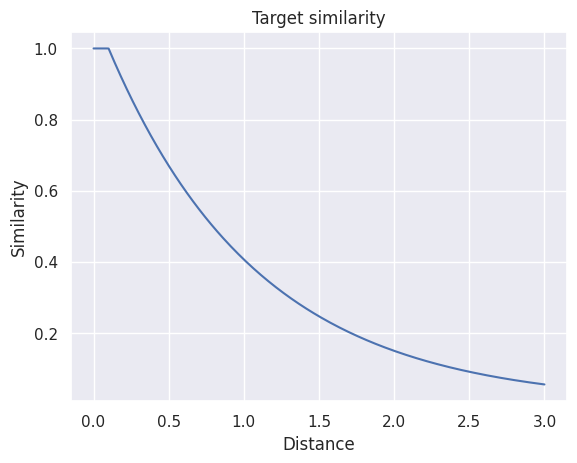

In [32]:
plt.plot(sim_dist, target_vals)
plt.xlabel('Distance')
plt.ylabel('Similarity')
plt.title('Target similarity')

Text(0.5, 1.0, 'Fitted curve')

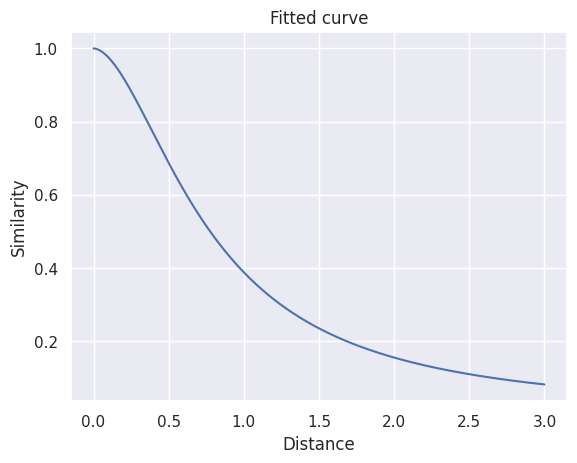

In [33]:
sim_dist = np.linspace(0, 3, 300)
similarities = optim_curve(sim_dist, a, b)
plt.plot(sim_dist, similarities)
plt.xlabel('Distance')
plt.ylabel('Similarity')
plt.title('Fitted curve')

### Low dimensional embedding optimization


In [34]:
# Initialize embedding with random values
embedding = np.random.uniform(
    low=-3.0, high=3.0, size=(sim_mtx.shape[0], N_COMPONENTS)
)

In [35]:
def euclidean_optim_one_epoch(sim_mtx_row_ids, sim_mtx_col_ids, a, b, embedding, weights, learning_rate, n_negative):
    # Iterate through pairs of samples and neighboirs
    # i represents sample index
    # j represents neighbour index
    for i,j in zip(sim_mtx_row_ids, sim_mtx_col_ids):

        # Get embeddings for sample and index
        p1 = embedding[i, :]
        p2 = embedding[j, :]

        # Find euclidean distance in low dimensional space
        dist_squared = np.sum(np.square(p1-p2))

        # Do full gradient calculation for neighbours if distance is greater than zero
        if dist_squared > 0:
            curr_grad = (
                weights[i]*2*a*b*dist_squared**(b-1) / (a*dist_squared**b + 1.)
                - (1-weights[i])*(2*b / ((0.001 + dist_squared)*(1+a*dist_squared**b)))
            )
        else:
            curr_grad = 0.

        curr_grad = curr_grad*(p1-p2)

        # Clip the gradients
        curr_grad = np.clip(curr_grad, -4., 4.)

        # Apply gradient to both, sample an neighbour
        embedding[i, :] -= curr_grad*learning_rate
        embedding[j, :] += curr_grad*learning_rate

        # Sample N random points and use them as "negative sample"
        # Negative sample is the sample that is not connected to the current sample
        for _ in range(n_negative):
            # Get randomly sample index
            neg_j = np.random.randint(embedding.shape[0])

            # Get embedding of negative sample
            p_neg = embedding[neg_j, : ]

            # Find euclidean distance between current sample and
            # negative sample
            dist_squared = np.sum(np.square(p1-p_neg))

            # Calculate gradient (formula is shorter because we assume weights[i]==0)
            # for thus case
            if dist_squared > 0.:
                curr_grad = -2.*b / ((0.001 + dist_squared)*(1+a*dist_squared**b))
            else:
                curr_grad = 0.

            curr_grad = curr_grad*(p1-p_neg)

            # Clip the gradient
            curr_grad = np.clip(curr_grad, -4., 4.)

            # Apply gradient to the both, sample and the neighbour
            embedding[i, :] -=  curr_grad*learning_rate
            embedding[neg_j, :] +=  curr_grad*learning_rate

# Optimize the function by using numba
optimize_fn = numba.njit(
    euclidean_optim_one_epoch, fastmath=True, parallel=False
)

In [36]:
euclidean_optim_one_epoch(
    sim_mtx_row_ids=sim_mtx_row_ids,
    sim_mtx_col_ids=sim_mtx_col_ids,
    a=a,
    b=b,
    embedding=embedding,
    weights=sim_mtx_vals,
    learning_rate=LEARNING_RATE,
    n_negative=N_NEGATIVE
)

In [37]:
optimize_fn(
    sim_mtx_row_ids=sim_mtx_row_ids,
    sim_mtx_col_ids=sim_mtx_col_ids,
    a=a,
    b=b,
    embedding=embedding,
    weights=sim_mtx_vals,
    learning_rate=LEARNING_RATE,
    n_negative=N_NEGATIVE
)

In [ ]:
# # Optimize in a loop
# for epoch_i in range(200):
#     optimize_fn(
#         sim_mtx_row_ids=sim_mtx_row_ids,
#         sim_mtx_col_ids=sim_mtx_col_ids,
#         a=a,
#         b=b,
#         embedding=embedding,
#         weights=sim_mtx_vals,
#         learning_rate=LEARNING_RATE,
#         n_negative=N_NEGATIVE
#     )

#     if epoch_i%20 == 0:
#         print(epoch_i)
#         test_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
#         test_df['label'] = mnist_label.values
#         sns.scatterplot(test_df,x='UMAP1', y='UMAP2', hue='label')
#         plt.show()

### Alternative function implementation with numba parallel

In [38]:
def euclidean_optim_one_epoch(sim_mtx_row_ids, sim_mtx_col_ids, a, b, embedding, weights, learning_rate, n_negative):
    # In order to uze numpa parallel, loop must be performed with numba.prange
    for iter_i in numba.prange(sim_mtx_row_ids.shape[0]):
        # Extract index for sample and neighbour
        i = sim_mtx_row_ids[iter_i]
        j = sim_mtx_col_ids[iter_i]

        # Get embeddings for sample and neighbour
        p1 = embedding[i, :]
        p2 = embedding[j, :]

        # Find euclidean distance in low dimensional space
        dist_squared = np.sum(np.square(p1-p2))

        # Do full gradient calculation for neighbours if distance is greater than zero
        if dist_squared > 0:
            curr_grad = (
                weights[i]*2*a*b*dist_squared**(b-1) / (a*dist_squared**b + 1.)
                - (1-weights[i])*(2*b / ((0.001 + dist_squared)*(1+a*dist_squared**b)))
            )
        else:
            curr_grad = 0.

        curr_grad = curr_grad*(p1-p2)

        # Clip the gradients
        curr_grad = np.clip(curr_grad, -4., 4.)

        # Apply gradient to both, sample an neighbour
        embedding[i, :] -= curr_grad*learning_rate
        embedding[j, :] += curr_grad*learning_rate

        # Sample N random points and use them as "negative sample"
        # Negative sample is the sample that is not connected to the current sample
        for _ in range(n_negative):
            # Get randomly sample index
            neg_j = np.random.randint(embedding.shape[0])

            # Get embedding of negative sample
            p_neg = embedding[neg_j, : ]

            # Find euclidean distance between current sample and
            # negative sample
            dist_squared = np.sum(np.square(p1-p_neg))

            # Calculate gradient (formula is shorter because we assume weights[i]==0)
            # for thus case
            if dist_squared > 0.:
                curr_grad = -2.*b / ((0.001 + dist_squared)*(1+a*dist_squared**b))
            else:
                curr_grad = 0.

            curr_grad = curr_grad*(p1-p_neg)

            # Clip the gradient
            curr_grad = np.clip(curr_grad, -4., 4.)

            # Apply gradient to the both, sample and the neighbour
            embedding[i, :] -=  curr_grad*learning_rate
            embedding[neg_j, :] +=  curr_grad*learning_rate

# Optimize the function
optimize_fn = numba.njit(
    euclidean_optim_one_epoch, fastmath=True, parallel=True
)

In [39]:
# Initialize embedding with random values
embedding = np.random.uniform(
    low=-3.0, high=3.0, size=(sim_mtx.shape[0], N_COMPONENTS)
)

0


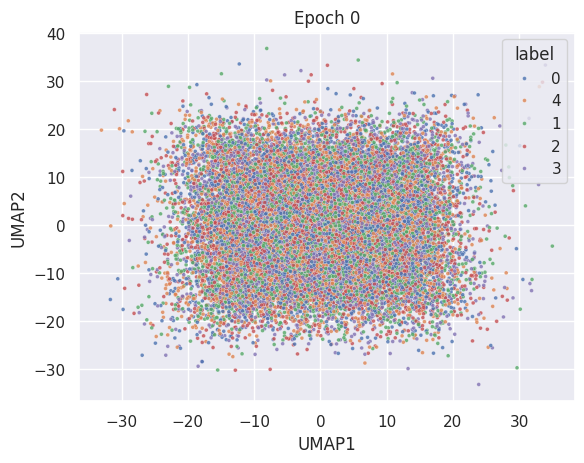

100


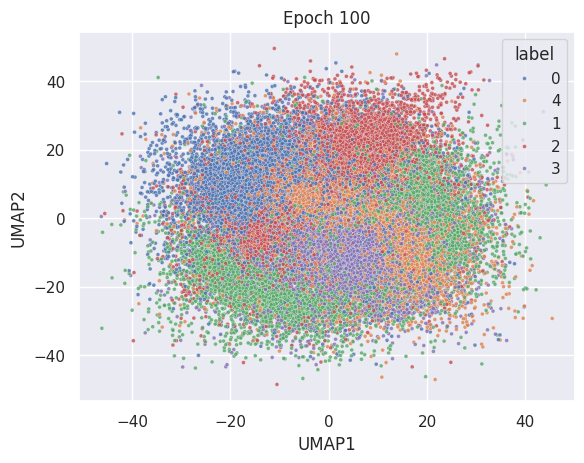

200


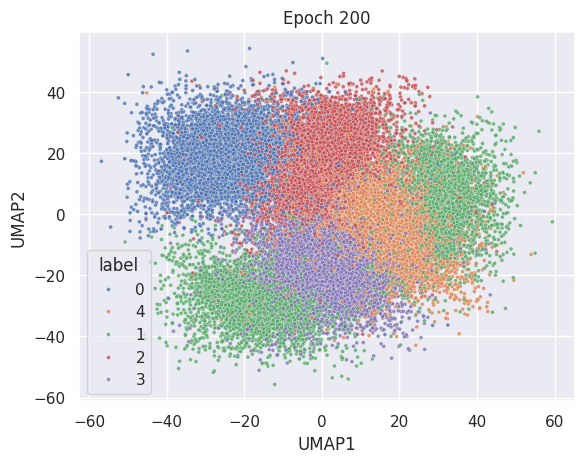

300


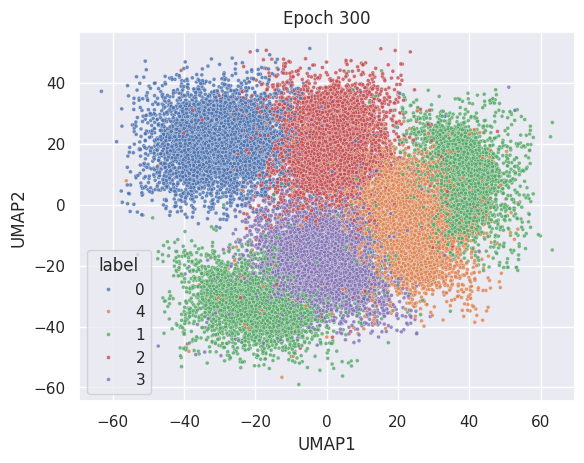

400


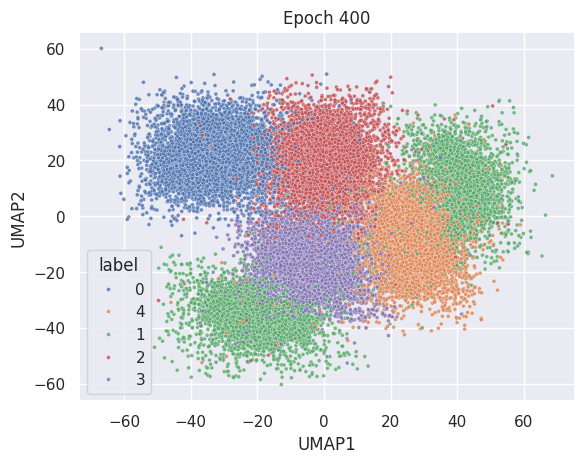

500


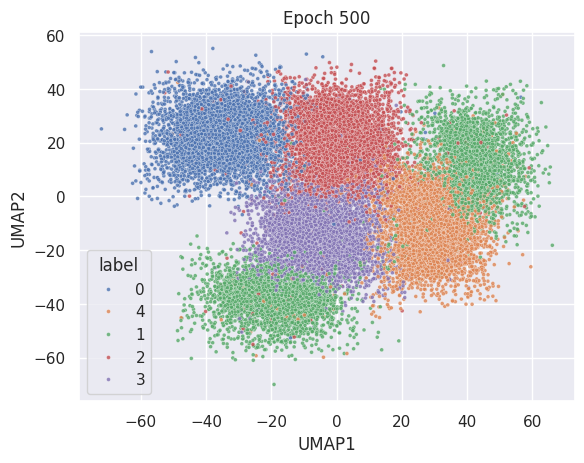

600


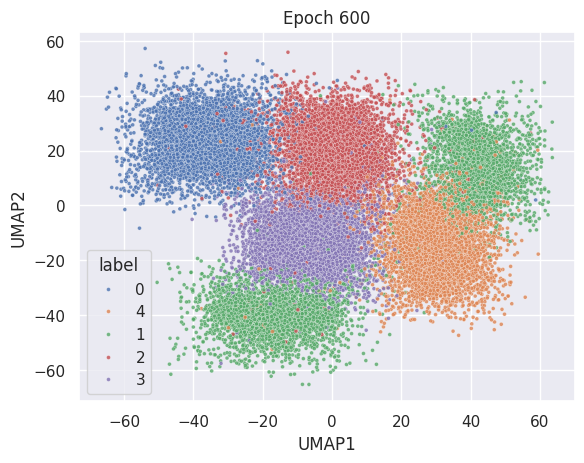

700


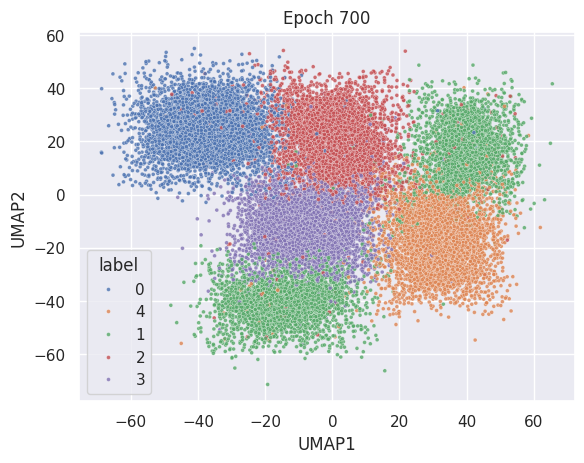

In [ ]:
# Optimize in a loop
for epoch_i in range(N_EPOCHS):
    optimize_fn(
        sim_mtx_row_ids=sim_mtx_row_ids,
        sim_mtx_col_ids=sim_mtx_col_ids,
        a=a,
        b=b,
        embedding=embedding,
        weights=sim_mtx_vals,
        learning_rate=LEARNING_RATE,
        n_negative=N_NEGATIVE
    )

    if epoch_i%100 == 0:
        print(epoch_i)
        test_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
        test_df['label'] = mnist_label.values
        sns.scatterplot(test_df,x='UMAP1', y='UMAP2', hue='label', alpha=0.8, s=8)
        plt.title('Epoch ' + str(epoch_i))
        plt.show()